Source: http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

## Translate Korean to English

### setup

In [1]:
# import libraries to work with strings
import unicodedata
import re
import random
import glob
import time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [4]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)

# useful tokens
SOS_token = 0
EOS_token = 1

data_path = '../data/en2ko/Corpus10/'

use_cuda = torch.cuda.is_available()

random.seed(7)

In [5]:
teacher_forcing_ratio = 0.5
hidden_size = 256

### model

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

### utils

In [9]:
# useful class to get the index for a word and get the word for an index
class Lang(object):
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        # n_words is the index of next new word
        self.n_words = 2 # Count SOS and EOS
    
    # no punctuation for these sentences
    def addSentence(self, sentence):
        for word in sentence.split():
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [10]:
def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
        len(p[1].split()) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [11]:
# Turn a Unicode string to plain ASCII
# thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s, lang='en'):
    s = unicodeToAscii(s.lower().strip().lstrip('#'))
    # remove all character after . or ! or ?
    s = re.sub(r"([.!?]).*", r" \1", s)
    if lang == 'en':
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [12]:
def read_file(filepath):
    pairs = []
    with open(filepath, 'rb') as f:
        while True:
            line = f.readline()
            if line == b"":
                break
            if line.startswith(b"["):
                en_sentence = f.readline().decode('korean')
                ko_sentence = f.readline().decode('korean')
                pairs.append([normalizeString(en_sentence),
                              normalizeString(ko_sentence, lang='ko')])
    return pairs

In [13]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('../data/%s-%s.txt'
    #             % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    #pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    pairs = []
    for filepath in glob.glob(data_path + "/*"):
        pairs += read_file(filepath)
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

In [14]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [15]:
int(3.1 / 2)

1

In [16]:
def asMinutes(s):
    m = int(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

### train

In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split()]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [20]:
def train(input_variable, target_variable, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion,
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = (True if random.random() < teacher_forcing_ratio
                           else False)

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output[0], target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [21]:
def trainEpochs(encoder, decoder, n_epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_epochs)]
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        training_pair = training_pairs[epoch - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                         epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [22]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### prepare

In [24]:
input_lang, output_lang, pairs = prepareData('en', 'ko', reverse=True)
print(random.choice(pairs))

Reading lines...
Read 62049 sentence pairs
Trimmed to 3305 sentence pairs
Counting words...
Counted words:
ko 6033
en 3581
['나는 많은 방면에서 다른 사람보다 뒤떨어진다 .', 'i am inferior to others in many respects .']


### run

5m 30s (- 77m 1s) (5000 6%) 3.8762
10m 48s (- 70m 15s) (10000 13%) 3.3924
16m 9s (- 64m 39s) (15000 20%) 3.0913
21m 32s (- 59m 15s) (20000 26%) 2.6815
26m 56s (- 53m 52s) (25000 33%) 2.2685
32m 19s (- 48m 28s) (30000 40%) 1.8582
37m 43s (- 43m 6s) (35000 46%) 1.4442
43m 7s (- 37m 43s) (40000 53%) 1.1431
48m 32s (- 32m 21s) (45000 60%) 0.8525
54m 0s (- 27m 0s) (50000 66%) 0.5800
59m 28s (- 21m 37s) (55000 73%) 0.4075
64m 58s (- 16m 14s) (60000 80%) 0.2811
70m 28s (- 10m 50s) (65000 86%) 0.1744
75m 57s (- 5m 25s) (70000 93%) 0.1094
81m 26s (- 0m 0s) (75000 100%) 0.0744


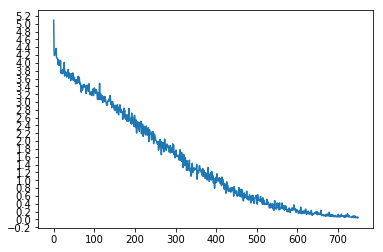

In [25]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainEpochs(encoder1, attn_decoder1, 75000, print_every=5000)

### test

In [26]:
evaluateRandomly(encoder1, attn_decoder1)

> 우리는 그러한 옛 관습들을 부흥하려고 노력하고 있다 .
= we are trying to revive the old customs .
< we are trying to revive the old customs . <EOS>

> 그녀는 현재 청도에서 휴양중이다 .
= she is now recuperation at tsingdao .
< she is now recuperation at tsingdao . <EOS>

> 그녀는 깨어있을 때는 늘 일을한다 .
= she spends all her waking hours working .
< she spends all her waking hours working . <EOS>

> 그는 나의 가까운 친척이다 .
= he s one of my closest relatives .
< he s one of my closest relatives . <EOS>

> 그는 그것을 말하고 나서 다시 원래의 주제로 돌아왔다 .
= he said that and then he harked back .
< he said that and then he harked back . <EOS>

> 그녀는 내막을 잘 안다; 그녀는 신임을 받았다 .
= she s on the inside .
< she s on the inside . <EOS>

> 그녀가 말한 것은 화요일이지만, 그녀가 가리키는 것은 목요일이다 .
= she said tuesday but she meant thursday .
< she said tuesday but she meant thursday . <EOS>

> 그는 단지 하고

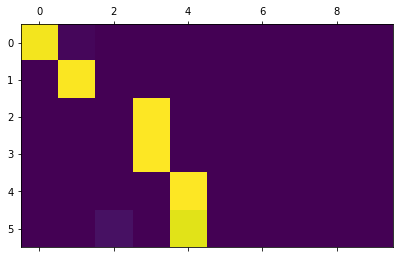

In [27]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "나는 문외한이다 .")
plt.matshow(attentions.numpy())

input = 나는 문외한이다 .
output = i am a student . <EOS>


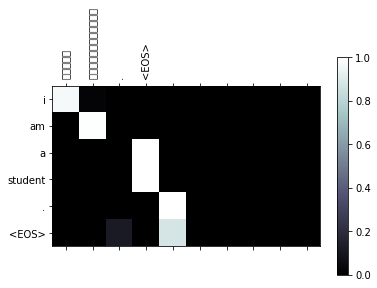

input = 그는 큰소리로 웨이터를 불렀다 .
output = he shouted for a waiter . <EOS>


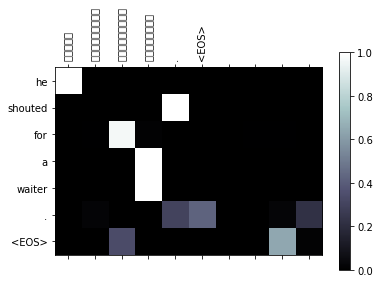

input = 그녀가 말한 것은 화요일이지만, 그녀가 가리키는 것은 목요일이다 .
output = she said tuesday but she meant thursday . <EOS>


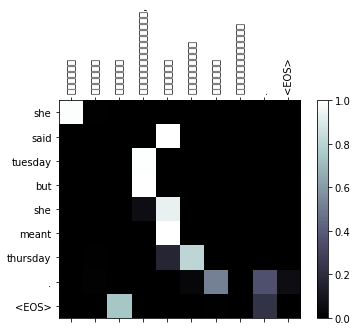

input = 그는 나의 가까운 친척이다 .
output = he s one of my closest relatives . <EOS>


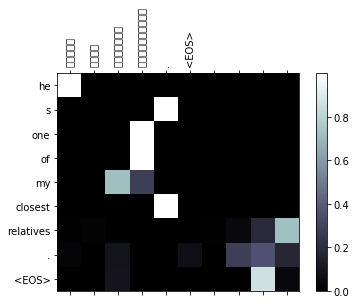

In [29]:
evaluateAndShowAttention("나는 문외한이다 .")

evaluateAndShowAttention("그는 큰소리로 웨이터를 불렀다 .")

evaluateAndShowAttention("그녀가 말한 것은 화요일이지만,"
                         " 그녀가 가리키는 것은 목요일이다 .")

evaluateAndShowAttention("그는 나의 가까운 친척이다 .")